[IPython Notebook](meshes.ipynb) |  [Python Script](meshes.py)

Accessing and Plotting Meshes
============================

Setup
-----------------------------

As always, let's do imports and initialize a logger and a new Bundle.  See [Building a System](building_a_system.html) for more details.

In [1]:
%matplotlib inline

In [2]:
import phoebe
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger(clevel='INFO')

b = phoebe.default_binary()

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


/usr/local/lib/python2.7/dist-packages/astropy/units/quantity.py:732: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return super(Quantity, self).__eq__(other)


The 'protomesh'
---------------------

The 'protomesh' is the mesh of each star in its own reference frame at periastron.  The coordinates are defined such that the x-axis points towards the other component in the parent orbit.

To build the protomesh, set 'protomesh' to be True, either in the compute options or directly as a keyword argument when calling run_compute.

In [3]:
b.run_compute(protomesh=True)

<ParameterSet: 30 parameters | components: primary, secondary>

You'll see that the resulting model has a single dataset kind ('mesh') and with a dataset tag of 'protomesh'.

In [4]:
print b['model'].kinds

['mesh']


In [5]:
print b['model'].datasets

['protomesh']


Now let's look at the parameters in the protomesh

In [6]:
b.filter(dataset='protomesh', context='model')

<ParameterSet: 30 parameters | components: primary, secondary>

In [7]:
b.filter(dataset='protomesh', context='model', component='primary')

<ParameterSet: 15 parameters | qualifiers: nzs, cosbetas, nxs, rs, tareas, nys, normals, vertices, teffs, loggs, xs, ys, areas, visible_centroids, zs>

In [8]:
b.get_value(dataset='protomesh', context='model', component='primary', qualifier='teffs')

array([ 9990.44010172,  9990.4559553 ,  9990.44010172, ...,  9998.86221175,
        9999.18998802,  9998.96270752])

/home/kyle/.local/lib/python2.7/site-packages/phoebe/frontend/plotting.py:242: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pckwargs['edgecolors'] in ['none', 'None', None] and pckwargs['facecolors'] not in ['none', 'None', None]:
/home/kyle/.local/lib/python2.7/site-packages/phoebe/frontend/plotting.py:242: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pckwargs['edgecolors'] in ['none', 'None', None] and pckwargs['facecolors'] not in ['none', 'None', None]:
/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


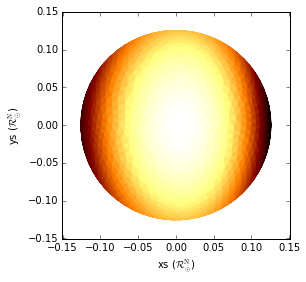

In [9]:
axs, artists = b.filter(dataset='protomesh', context='model', component='secondary').plot(facecolor='teffs', edgecolor=None)

The 'pbmesh'
----------------------

'pbmesh' is an automatically-created dataset in the returned model which stores the mesh at every time-point at which it was required to be built by other existing datasets.

Again, these will only be stored in the returned model if pbmesh=True is passed during run_compute or is True in the passed compute options.

In [10]:
b.add_dataset('lc', times=[0,1,2], dataset='lc01')

<ParameterSet: 14 parameters | contexts: compute, dataset>

In [11]:
b.run_compute(pbmesh=True)

<ParameterSet: 184 parameters | kinds: mesh, lc>

Our model now has dataset kinds for both the 'mesh' and 'lc' and has dataset tags for our newly-created 'lc01' dataset as well as the 'pbmesh' datasets in the model created only because pbmesh=True.

In [12]:
print b['model'].kinds

['mesh', 'lc']


In [13]:
print b['model'].datasets

['lc01', 'pbmesh']


This time let's look at the parameters in the 'pbmesh' dataset of the model.

In [14]:
b.filter(dataset='pbmesh', context='model')

<ParameterSet: 146 parameters | components: primary, secondary>

In [15]:
b.filter(dataset='pbmesh', context='model', component='primary')

<ParameterSet: 73 parameters | qualifiers: loggs, pot, xs, zs, mus, rs, nys, r_projs, teffs, vzs, vxs, volume, rpole, ys, areas, nzs, vys, cosbetas, nxs, tareas, vertices, times, visibilities, normals, visible_centroids>

As you can see, the intensities are not available here - their dataset tags match the dataset of the light curve.  Instead let's access the mesh by dataset-kind:

In [16]:
b.filter(kind='mesh', context='model', component='primary')

<ParameterSet: 91 parameters | datasets: lc01, pbmesh>

In [17]:
b.filter(dataset='lc01', kind='mesh', context='model', component='primary')

<ParameterSet: 18 parameters | qualifiers: normal_intensities, ampl_boosts, abs_intensities, abs_normal_intensities, intensities, pblum>

To plot the intensities as color on the mesh, we can just plot the mesh and then reference the correct column by using twig access:

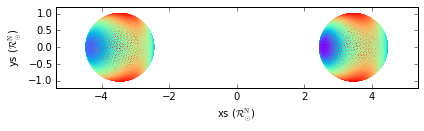

In [18]:
axs, artists = b.filter(kind='mesh', context='model', time=1.0).plot(facecolor='intensities@lc01', edgecolor='teffs')

The 'Mesh' Dataset Kind
----------------------

If you want to force the plot itself to build at specific times but not have any observables (necessarily) computed or filled at those times, you can create a mesh dataset.

Let's create a mesh dataset that fills in the missing times from our lc dataset.

In [19]:
b.get_value('times@lc01@dataset')

array([ 0.,  1.,  2.])

In [20]:
b.add_dataset('mesh', times=[0.5, 1.5], dataset='mesh01')

<ParameterSet: 2 parameters | contexts: compute, dataset>

Now let's run_compute with protomesh and pbmesh set to False (these will default to the values in the compute options - which themselves are defaulted to False).

In [21]:
b.run_compute(protomesh=False, pbmesh=False)

<ParameterSet: 124 parameters | kinds: mesh, lc>

As expected, the resulting model has dataset kinds for both mesh and lc, as well as datasets for 'mesh01' and 'lc01' - but the 'pbmesh' and 'protomesh' entries are no longer created (since protomesh and pbmesh are both  False).

In [22]:
print b['model'].kinds

['mesh', 'lc']


In [23]:
print b['model'].datasets

['mesh01', 'lc01']


The meshes are only stored at the times of the mesh dataset - not at the times of the lc dataset.

In [24]:
b.filter(kind='mesh', context='model').times

['1.5', '0.5']

Since there was no lc requested at these times, the 'intensities' columns will be empty.

In [25]:
b.get_value(kind='mesh', context='model', dataset='lc01', time=0.5, qualifier='intensities', component='primary')

array([], dtype=float64)

But we can still plot any of the dataset-independent quantities

In [26]:
b.filter(dataset='mesh01', kind='mesh', context='model', component='primary', time=0.5)

<ParameterSet: 24 parameters | qualifiers: loggs, pot, xs, zs, mus, rs, nys, r_projs, teffs, vzs, vxs, volume, rpole, ys, areas, nzs, vys, cosbetas, nxs, tareas, vertices, visibilities, normals, visible_centroids>

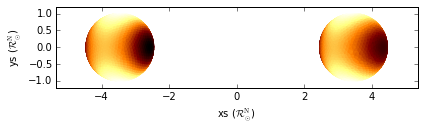

In [27]:
axs, artists = b.filter(dataset='mesh01', kind='mesh', context='model', time=0.5).plot(facecolor='teffs', edgecolor=None)

If you want the meshes stored at both the times in the 'mesh' dataset and all /other/ datasets, simply set pbmesh to True.

In [28]:
b.run_compute(pbmesh=True)

<ParameterSet: 306 parameters | kinds: mesh, lc>

In [29]:
b.filter(kind='mesh', context='model').times

['1.5', '0.5', '2.0', '1.0', '0.0']